In [1]:
import sys
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

<module 'data_loading' from '../../data_loading.py'>

In [2]:
reload(dl)
dl.get_pot_trig(1, "runs", "bnb")

(1.67e+20, 37094101)

In [8]:
reload(dl)
RUN = 1
rundata = dl.load_run(
    RUN,
    "bnb",
    # truth_filtered_sets=["nue", "nc_pi0"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
)

In [9]:
rundata.keys()

dict_keys(['data', 'ext', 'nu'])

In [10]:
rundata["nu"]

,reco_nu_vtx_z,shrmoliereavg,pi0_dedx2_fit_U,pi0truth_gamma2_etot,pi0truth_gamma1_ypos,trk1trk2hitdist2,shr_hits_u_tot,shr_py,nu_e,trk_energy_tot,...,dy,dz,dr,bnbdata,extdata,paper_category,paper_category_xsec,paper_category_numu,dataset,weights
entry,,,,,,,,,,,,,,,,,,,,,
0,843.589233,12.082662,1.875918,36.147484,97.675491,-1.000000,67,0.092081,1.244641,0.000000,...,15.266212,4.308716,15.863662,False,False,31,31,0,nu,0.127481
1,230.572403,5.501115,1.735898,27.536312,-91.012932,0.300567,206,-0.148889,1.775601,1.058040,...,0.536469,0.900528,1.059277,False,False,21,21,0,nu,0.127481
2,117.988724,9.538054,2.788811,61.761944,-51.576298,-1.000000,63,0.060284,0.786414,0.060903,...,0.278091,0.042976,0.282232,False,False,31,31,0,nu,0.127481
3,948.284729,4.523560,1.913763,111.843819,59.712772,-1.000000,219,0.115942,1.372105,0.000000,...,-0.671393,-4.739807,8.048138,False,False,31,31,0,nu,0.127481
4,243.183838,13.485046,3.266756,165.416321,9.763727,0.644786,42,-0.038693,1.253954,0.559085,...,-0.033375,1.331528,1.478455,False,False,21,21,0,nu,0.127481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31972,213.449890,157.641113,1.879965,67.109810,-79.032249,1.212923,95,0.024622,4.202887,0.636401,...,-0.163597,-0.085312,0.184874,False,False,31,31,0,nu,0.127481
31973,688.612000,11.989759,1.879965,23.455706,100.387543,-1.000000,97,0.035154,0.630285,0.000000,...,6.193542,15.224609,19.175558,False,False,31,31,0,nu,0.127481
31974,674.297913,5.460643,1.879965,0.000000,0.000000,-1.000000,0,-0.055857,1.104792,0.173862,...,0.897413,0.985657,2.274971,False,False,2,2,0,nu,0.143140


In [15]:
rundata["nu"]["weightsGenie"][0]

array([ 769,  590,  992,  814, 1442,  568,  915,  421,  448, 1400,  905,
        942, 1977, 1316,  940,  402, 1022, 1535, 1323, 1003,  648, 1288,
       1316,  403, 1837,  829,  737,  667,  425,  378, 1262, 1355,  637,
        489, 1241,  423, 1122,  407,  693, 1710,  608, 1406,  595,  816,
       1322,  975,  413, 1841,  746,  412, 1234,  952,  987,  931, 1030,
        236,  586, 1577,  608, 1036,  657,  317,  902,  834, 1351,  547,
        377, 2146, 1247,  373, 1317,  688, 1001, 1265,  801,  487,  342,
        548, 1033, 1506, 1508, 1179,  829,  969,  436, 1242, 1029, 1558,
        781, 1333,  456, 1252,  791,  590, 1179, 1074,  447, 1276,  643,
       1197], dtype=uint16)

In [20]:
import pandas as pd
for k, df in rundata.items():
    df["label"] = k
    df["label"] = df["label"].astype("category")
# make one dataframe for all events except for "data"
df = pd.concat([df for k, df in rundata.items() if k != "data"])
df_bnb = rundata["data"]

In [21]:
from unblinding_far_sideband import selection_categories, basic_variables, preselection_categories

Data bin counts: [ 0  3 16  6  7  4  2  5  0  1  0  2  0  0  0  1  2]


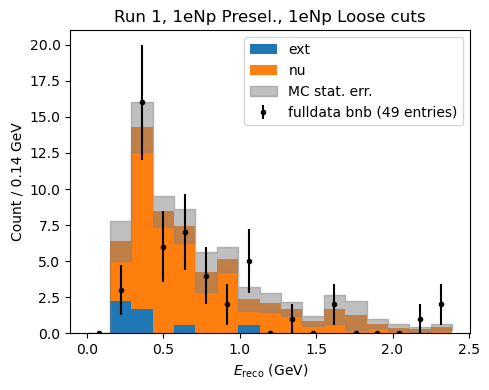

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


VARIABLE, BINS, RANGE, XTIT = "reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]"
labels = df["label"].unique()

selection = "NPL"
preselection = "NP"

presel_query = preselection_categories[preselection]["query"]
presel_title = preselection_categories[preselection]["title"]

sel_query = selection_categories[selection]["query"]
sel_title = selection_categories[selection]["title"]

if presel_query is None:
    query = sel_query
    presel_title = "No Presel."
elif sel_query is None:
    query = presel_query
    sel_title = "No Sel."
else:
    query = f"{presel_query} and {sel_query}"

fig, ax = plt.subplots(figsize=(5, 4))

bnb_filtered = df_bnb.query(query)

# Plot the beam-on data (bnb) on top as points with error bars
hist, bin_edges = np.histogram(bnb_filtered[VARIABLE], bins=BINS, range=RANGE)
hist_err = np.sqrt(hist)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.0
bin_width = (bin_edges[1:] - bin_edges[:-1])[0]
entries = np.sum(hist)
ax.errorbar(bin_centers, hist, yerr=hist_err, fmt=".", color="black", label=f"fulldata bnb ({entries:.0f} entries)")

print(f"Data bin counts: {hist}")

# Plot the MC as a stacked histogram
data = [df.query(query).loc[df.query(query)["label"] == lbl, VARIABLE] for lbl in labels]
weights = [df.query(query).loc[df.query(query)["label"] == lbl, "weights"] for lbl in labels]

ax.hist(data, bins=BINS, range=RANGE, stacked=True, label=labels, weights=weights)

# Calculate the total statistical MC error in each bin and plot it as a shaded region.
# Use the sum of squared weights in each bin as the variance. We want to sum over all
# of the stacked histograms.
hist_mc_var, _ = np.histogram(np.concatenate(data), bins=BINS, range=RANGE, weights=np.concatenate(weights) ** 2)
hist_mc_err = np.sqrt(hist_mc_var)
hist_mc_tot, _ = np.histogram(np.concatenate(data), bins=BINS, range=RANGE, weights=np.concatenate(weights))
# Draw shaded band from hist_mc_tot - hist_mc_err to hist_mc_tot + hist_mc_err
mc_err_lo = hist_mc_tot - hist_mc_err
mc_err_hi = hist_mc_tot + hist_mc_err
# Fill between the upper and lower error bounds with stepped line
ax.fill_between(
    bin_edges,
    np.append(mc_err_lo, mc_err_lo[-1]),
    np.append(mc_err_hi, mc_err_hi[-1]),
    step="post",
    color="gray",
    alpha=0.5,
    label="MC stat. err.",
)

ax.legend()

ax.set_xlabel(r"$E_\mathrm{reco}$ (GeV)")
ax.set_ylabel(f"Count / {bin_width:.2f} GeV")
ax.set_title(f"Run {RUN}, {presel_title}, {sel_title}")

fig.tight_layout()

# fig.savefig(f"run{RUN}_{presel_title.replace(' ', '_').lower()}_{sel_title.replace(' ', '_').lower()}.pdf")